# Predict TripAdvisor Rating

## Задание
Необходимо предсказать рейтинг ресторана в TripAdvisor.

## Описание признаков

- Restaurant_id — идентификационный номер ресторана / сети ресторанов;
- City — город, в котором находится ресторан;
- Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
- Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
- Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
- Price Range — диапазон цен в ресторане;
- Number of Reviews — количество отзывов о ресторане;
- Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
- URL_TA — URL страницы ресторана на TripAdvisor;
- ID_TA — идентификатор ресторана в базе данных TripAdvisor.

## Загрузка необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

import warnings; warnings.simplefilter('ignore')

In [2]:
# Фиксируем RANDOM SEED

RANDOM_SEED = 42

In [3]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы

!pip freeze > requirements.txt

## Функции, которые нам могут понадобиться.

In [4]:
# Создадим функция для определения границ выбросов.

def find_IQR(column):
    perc_25 = data[column].quantile(0.25, interpolation="midpoint")
    perc_75 = data[column].quantile(0.75, interpolation="midpoint")
    IQR = perc_75 - perc_25
    print('Q1: {}'.format(perc_25), 'Q3: {}'.format(perc_75), 'IQR: {}'.format(IQR),
          'Граница выбросов: [{a},{b}]'.format(a=perc_25 - 1.5*IQR, b=perc_75 + 1.5*IQR), sep='\n')

## Data

In [5]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
df_train.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
15642,id_6059,Barcelona,['Italian'],6060.0,3.5,NaN,3.0,"[[], []]",/Restaurant_Review-g187497-d1074450-Reviews-A_...,d1074450
21997,id_5478,Paris,['Japanese'],5479.0,5.0,$$ - $$$,12.0,"[['Simple affordable Japanese restaurant', 'Mu...",/Restaurant_Review-g187147-d8574680-Reviews-Sa...,d8574680
39761,id_1957,Paris,"['French', 'European', 'Vegetarian Friendly']",1958.0,4.0,$$ - $$$,287.0,"[['Cute restaurant in Montmartre', 'I will not...",/Restaurant_Review-g187147-d1907374-Reviews-Le...,d1907374
38350,id_555,Munich,NaN,560.0,4.5,NaN,27.0,"[[], []]",/Restaurant_Review-g187309-d11659115-Reviews-T...,d11659115
15628,id_1519,Stockholm,NaN,1521.0,4.0,NaN,4.0,"[['We enjoyed it. right for the evening'], ['0...",/Restaurant_Review-g189852-d3303412-Reviews-Ga...,d3303412


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


Для корректной обработки признаков объединяем train и test в один датасет.

In [12]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [14]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
31568,id_8242,Paris,"['Chinese', 'Asian', 'Taiwanese']",8243.0,$,NaN,"[[], []]",/Restaurant_Review-g187147-d13094987-Reviews-T...,d13094987,1,5.0
37095,id_3628,Lisbon,NaN,3633.0,NaN,4.0,"[[], []]",/Restaurant_Review-g189158-d12439450-Reviews-S...,d12439450,1,3.5
26824,id_715,Oslo,"['European', 'Scandinavian', 'Norwegian']",716.0,$,7.0,"[['Great bar & bike shop', 'Spunky Scandinavia...",/Restaurant_Review-g190479-d10701863-Reviews-O...,d10701863,1,4.5
31392,id_1241,Warsaw,"['Asian', 'Thai', 'Vietnamese']",1242.0,$,2.0,"[[], []]",/Restaurant_Review-g274856-d12593386-Reviews-Z...,d12593386,1,4.5
48708,id_5253,Milan,['Italian'],5256.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187849-d1021643-Reviews-Br...,d1021643,1,3.5


В нашем получившемся общем датасете мы видим 10 признаков (sample не считаем, так как это искуственный признак для дальнейшего разделения датасета). Три признака заполнены числовыми значениями, остальные номинативными. Что содержится в каждом из признаков посмотрим дальше, являются ли они категориальными и т.д. В некоторых признаках содержится достаточно большое количество пропусков.
По условиям задания мы не можем удалять строки, так что будем заполнять пропуски и, возможно, создавать отдельный признак пропусков, так как отсуствия значения может быть также важной информацией для модели.

Переименуем колонки для удобства обращения к признакам.

In [15]:
data.rename(columns={'Restaurant_id': 'rest_id', 'City': 'city',
                     'Cuisine Style': 'cuisine_style', 'Ranking': 'ranking',
                     'Rating': 'rating', 'Price Range': 'price_range',
                    'Number of Reviews': 'number_of_rev', 'Reviews': 'reviews',
                    'URL_TA': 'url_ta', 'ID_TA': 'id_ta'}, inplace=True)

In [16]:
# проверим

data.columns

Index(['rest_id', 'city', 'cuisine_style', 'ranking', 'price_range',
       'number_of_rev', 'reviews', 'url_ta', 'id_ta', 'sample', 'rating'],
      dtype='object')

## Cleaning and Prepping Data

In [17]:
# посмотрим на кол-во пропусков, с которым предстоит работать

data.isnull().sum()

rest_id              0
city                 0
cuisine_style    11590
ranking              0
price_range      17361
number_of_rev     3200
reviews              2
url_ta               0
id_ta                0
sample               0
rating               0
dtype: int64

### ['rest_id']

Не уверена, что данный признак будет полезен для модели. Однако визуально видна зависимость между данным признаком и признаком ranking. Посмотрим на корреляцию.

In [18]:
data.rest_id = data.rest_id.apply(lambda x: float(x[3:]))

In [19]:
data[['rest_id', 'ranking']].corr()

,rest_id,ranking
rest_id,1.00000,0.82509
ranking,0.82509,1.00000


Да, корреляция есть. В таком случае признак rest_id потом удалим. Пока оставим, может пригодиться для формирования новых признаков.

### ['city']

In [20]:
data.city.describe()

count      50000
unique        31
top       London
freq        7193
Name: city, dtype: object

In [21]:
data.city.value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: city, dtype: int64

В данном признаки нет пропусков. На конечном этапе закодируем данный признак с помощью get_dummies. Пока оставим, как есть, для удобства создания новых признаков при необходимости.

### ['number_of_rev']

In [22]:
data.number_of_rev.describe()

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: number_of_rev, dtype: float64

In [23]:
data.number_of_rev.isnull().sum()

3200

У нас присутствует 3200 пропусков. Отсутствие данного значения может быть важной информацией для модели. Поэтому давайте вынесем все пропуски в отдельный признак. А пропуски заполним нулем.

In [24]:
data['number_of_rev_is_NAN'] = pd.isna(data.number_of_rev).astype('uint8')

In [25]:
data.number_of_rev.fillna(0, inplace=True)

In [26]:
# посмотрим, есть ли выбросы

find_IQR('number_of_rev')

Q1: 7.0
Q3: 105.0
IQR: 98.0
Граница выбросов: [-140.0,252.0]


Посмотрим, сколько значений у нас выбиывается за верхнюю границу выбросов.

In [27]:
sum(data.number_of_rev > 252)

5946

Достаточно много. Посмотрим распределение на гистограмме, чтобы не отсекать сразу так много.

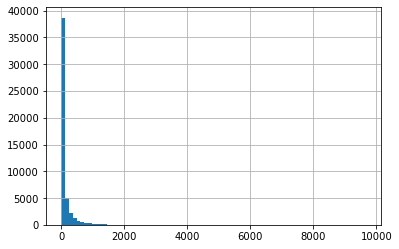

In [28]:
data.number_of_rev.hist(bins=80)

Так, мы видим что гистограмма смещена вправо, хвост длинный и уходит на убыль где-то в районе значения 1200. Посмотрим, сколько у нас значения больше 1200.

In [29]:
sum(data.number_of_rev > 1200)

571

Давайте заменим эти значения на 1200.

In [30]:
data.number_of_rev = data.number_of_rev.apply(lambda x: 1200 if x > 1200 else x)

In [31]:
# проверим

data.number_of_rev.describe()

count    50000.000000
mean       107.395580
std        204.081303
min          0.000000
25%          7.000000
50%         28.000000
75%        105.000000
max       1200.000000
Name: number_of_rev, dtype: float64

### ['price_range']

In [32]:
data.price_range.value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: price_range, dtype: int64

In [33]:
sum(data.price_range.isnull())

17361

Вынесем пропуски в отдельный признак, присвоим значениям порядковый номер, пропуски заменим на ноль.

In [34]:
price = {'$' : 1, '$$ - $$$' : 2, '$$$$' : 3}
data.price_range = data.price_range.map(price)

In [35]:
data.price_range.describe()

count    32639.000000
mean         1.815129
std          0.509800
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: price_range, dtype: float64

In [36]:
data['price_range_is_NAN'] = pd.isna(data.price_range).astype('uint8')

In [37]:
data.price_range = data.price_range.fillna(0)

In [38]:
# посмотрим, что получилось

data.price_range.value_counts()

2.0    23041
0.0    17361
1.0     7816
3.0     1782
Name: price_range, dtype: int64

### ['id_ta']

Не уверена, что данный признак нам пригодится, но давайте пока есть оставим и посмотрим в модели по значимости признака. Уберем все лишнее.

In [39]:
data.id_ta.value_counts()

d11999956    2
d4748208     2
d10440367    2
d2010743     2
d13002276    2
            ..
d7144321     1
d3528347     1
d10682586    1
d778842      1
d8319732     1
Name: id_ta, Length: 49963, dtype: int64

Интересно, у нас есть рестораны с одним и тем же идентификатором в системе. Давайте посмотрим на них поподробнее. 

In [40]:
# посмотрим, сколько у нас таких ресторанов

sum(data.id_ta.value_counts() > 1)

37

А если вернуться к колонке rest_id и посмотреть, есть ли там дважды встречающиеся значения

In [41]:
data.rest_id.value_counts()

871.0      19
227.0      19
436.0      19
633.0      19
344.0      18
           ..
11420.0     1
6603.0      1
8793.0      1
5548.0      1
11783.0     1
Name: rest_id, Length: 13094, dtype: int64

In [42]:
sum(data.rest_id.value_counts() >= 2)

9287

В ситуации с rest_id можно предположить, что это сеть ресторанов, как Макдональдс. Следственно затем мы можем создать признак, который бы указывал, является ли ресторан частью сети или нет. В ситуации с id_ta может быть это некая компания, которая владеет несколькими разными ресторанами. Сказать сложно. Давайте отфильтруем эти значения и посмотрим на них повнимательнее.

In [43]:
data.rest_id.nunique()

13094

In [44]:
data_id_ta_notunique = data[data['id_ta'].map(data['id_ta'].value_counts()) > 1]

In [45]:
data_id_ta_notunique.id_ta = data_id_ta_notunique.id_ta.apply(lambda x: int(x[1:]))

In [46]:
data_id_ta_notunique.id_ta.value_counts()

987900      2
10316215    2
1235635     2
4748208     2
10440367    2
11698990    2
1568045     2
4914988     2
13002276    2
4600226     2
12488993    2
7337366     2
3748757     2
1028622     2
9877640     2
1315077     2
5617412     2
697406      2
7809594     2
2010743     2
7827387     2
10047799    2
2669414     2
3161682     2
2360290     2
11674463    2
2477531     2
5618007     2
11921719    2
11999956    2
7342803     2
793170      2
3396817     2
8753348     2
3685055     2
3647024     2
9802625     2
Name: id_ta, dtype: int64

In [47]:
# посмотрим на пару таких ресторанов

data_id_ta_notunique.query('id_ta == 987900')

,rest_id,city,cuisine_style,ranking,price_range,number_of_rev,reviews,url_ta,id_ta,sample,rating,number_of_rev_is_NAN,price_range_is_NAN
18019,2361.0,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...",2363.0,2.0,190.0,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,987900,1,4.0,0,0
32998,2312.0,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...",2314.0,2.0,190.0,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,987900,1,4.0,0,0


Мы видим, что все значения, кроме rest_id совпадают, может у них название разное и разный url? Посмотрим.

In [48]:
data_id_ta_notunique.url_ta[18019]

'/Restaurant_Review-g187514-d987900-Reviews-Compostela_Restaurante-Madrid.html'

In [49]:
data_id_ta_notunique.url_ta[32998]

'/Restaurant_Review-g187514-d987900-Reviews-Compostela_Restaurante-Madrid.html'

Нет, и тут все одинаковое. Значит у нас 37 ресторанов в датасете дублируются. Однако по условиям задачи удалять строки из датасета нельзя. Поэтому не трогаем эти дубликаты. Возможно, затем колонку id_ta удалим за ненадобностью, пока просто уберем символ d в начале и приведем к числовому значению и пойдем дальше.

In [50]:
data.id_ta = data.id_ta.apply(lambda x: int(x[1:]))

### ['url_ta']

In [51]:
data.loc[data.url_ta[0]:5]

,rest_id,city,cuisine_style,ranking,price_range,number_of_rev,reviews,url_ta,id_ta,sample,rating,number_of_rev_is_NAN,price_range_is_NAN
0,0.0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,10746918,0,0.0,0,0
1,1.0,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,6674944,0,0.0,0,0
2,2.0,Edinburgh,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,13129638,0,0.0,0,0
3,3.0,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,680417,0,0.0,0,0
4,4.0,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,1112354,0,0.0,0,0
5,5.0,Paris,"['French', 'Cafe', 'Fast Food']",5093.0,1.0,24.0,"[['Lunch Break', 'Good to Quick Bite'], ['09/0...",/Restaurant_Review-g187147-d8458643-Reviews-Le...,8458643,0,0.0,0,0


In [52]:
data.url_ta[0]

'/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html'

In [53]:
data.url_ta[1]

'/Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html'

Мы видим, что url ресторана состоит из двух закодированных величин. Первая, судя по совпадениям, означает город, вторая совпадает с id_ta. Парсинг данных мы в данной задаче мы не используем. 
Давайте отделим код города.

In [54]:
data.url_ta = data.url_ta.apply(lambda x: x[20:26])

In [55]:
data.url_ta = data.url_ta.apply(lambda x: float(x))

In [56]:
data.url_ta[1]

189934.0

У нас осталось еще два признака, которые мы не трогали - стиль кухни и сами отзывы. Так как это текстовые объекты, а нам для модели необходимы числовые, то данные признаки сами по себе мы обработать не можем, но можем на их основе создать новые числовые, чем и займемся.

## Feature Engineering

### ['cuisine_style']

In [57]:
type(data.cuisine_style[0])

str

In [58]:
data.cuisine_style.isnull().sum()

11590

У нас 11590 пустых значений. Давайте вынесем их в отдельный признак. Предположим, что ресторан и сам не определился со стилем кухни, поэтому ничего не указывает. И может это будет полезно для модели.

In [59]:
data['cuisine_style_is_NAN'] = pd.isna(data.cuisine_style).astype('uint8')

In [60]:
# Пустые значения заполним категорией Other.

data.cuisine_style = data.cuisine_style.fillna("['Other']")

In [61]:
# переформатируем строку в список

data.cuisine_style = data.cuisine_style.apply(lambda x: eval(x))

Добавим признак кол-ва кухонь в ресторане.

In [62]:
data['number_of_cuisines'] = data.cuisine_style.apply(lambda x: len(x))

Посмтрим, какие кухни у нас чаще всего встречаются, а какие наоборот являются самыми редкими.

In [63]:
group_city_cuisine = data.groupby(['city'])['cuisine_style'].sum().reset_index()

Посчитаем кол-во уникальных кухонь, используя счетчик. Посмотрим, какие кухни входят топ-10, как самые часто встречающиеся и как самые редко встречающиеся.

In [64]:
c = collections.Counter()

for cuisine_style in group_city_cuisine.cuisine_style:
    for x in cuisine_style:
        c[x] += 1

print(c.most_common(10))
print()
print(c.most_common()[-10:])

[('Vegetarian Friendly', 14021), ('European', 12561), ('Other', 11590), ('Mediterranean', 7820), ('Italian', 7433), ('Vegan Options', 5684), ('Gluten Free Options', 5185), ('Bar', 4094), ('French', 3970), ('Asian', 3786)]

[('Caucasian', 4), ('Azerbaijani', 3), ('Welsh', 3), ('Yunnan', 2), ('Polynesian', 2), ('Fujian', 2), ('Latvian', 1), ('Burmese', 1), ('Salvadoran', 1), ('Xinjiang', 1)]


Добавим признак, имеет ли ресторан кухню, входящую в топ-10 по популярности и по редкости.

In [65]:
# сначала признак самых часто встречающихся кухонь

top_10_cuisine = []
top_10_cuisine = data.explode('cuisine_style')['cuisine_style'].value_counts()[
    data.explode('cuisine_style')['cuisine_style'].value_counts() >= 3786].index.tolist()

In [66]:
def most_common_cuisines(column):
    x = 0
    for i in top_10_cuisine:
        if i in column:
            x += 1
    return x

data['most_common_cuisine'] = data.cuisine_style.apply(most_common_cuisines)

In [67]:
# теперь самые редкие

top_unique_cuisine = []
top_unique_cuisine = data.explode('cuisine_style')['cuisine_style'].value_counts()[
    data.explode('cuisine_style')['cuisine_style'].value_counts() <= 4].index.tolist()

In [68]:
def top_unique_cuisines(column):
    x = 0
    for i in top_unique_cuisine:
        if i in column:
            x += 1
    return x

data['top_unique_cuisine'] = data.cuisine_style.apply(top_unique_cuisines)

Пока идем дальше, возможно, дальше еще какую-нибудь информацию сможем получить из признака кухонь.

### ['reviews']

In [69]:
data.reviews.isnull().sum()

2

In [70]:
data.reviews.value_counts()

[[], []]                                                                                                              8112
[['Nice restaurant in Madrid', 'Highly reccomended'], ['11/10/2017', '05/21/2017']]                                      2
[['Delicious'], ['06/06/2017']]                                                                                          2
[['Good service and clean', 'Chinese fusion cuisine - ok to try if you...'], ['11/21/2017', '05/23/2017']]               2
[['Happened to drop in', 'Right for a quick bite'], ['11/30/2016', '06/20/2015']]                                        2
                                                                                                                      ... 
[['nice place, good food and frendly service', 'Fine Chinese Food'], ['08/30/2014', '08/14/2014']]                       1
[['Christmas Lunch', 'Amazing food and ambience'], ['12/25/2017', '12/12/2017']]                                         1
[['Wonderful loc

Итак, мы видим, что данный признак состоит из текстового отзыва и даты. У нас есть два пропуска явных и 8112 пропусков не явных, не имеющих внутри ничего кроме скобок. Отсутствие отзыва может быть важным для модели. Поэтому давайте вынесем все отзывы в отдельных признак.

In [71]:
data['review_is_NAN'] = (data.reviews == '[[], []]').astype('uint8')

In [72]:
data['review_is_NAN'] = pd.isna(data.reviews).astype('uint8')

Отделим дату от отзыва и посмотрим, какую информацию мы можем получить из даты.

In [73]:
data['date_of_review'] = data['reviews'].apply(
    lambda x: [0] if pd.isna(x) else x[2:-2].split('], [')[1][1:-1].split("', '"))

Добавим признак кол-ва дней между отзывами.

In [74]:
data['days_between_reviews'] = data.date_of_review.apply(lambda x: None if x == [] else pd.to_datetime(x).max() - pd.to_datetime(x).min())

In [75]:
# посмторим на показатели

data.days_between_reviews.describe()

count                       41888
mean     123 days 05:05:55.462184
std      212 days 14:08:22.315988
min               0 days 00:00:00
25%               8 days 00:00:00
50%              49 days 00:00:00
75%             148 days 00:00:00
max            3296 days 00:00:00
Name: days_between_reviews, dtype: object

У нас есть максимальное значение в 3296 дней. Давайте переведем значения в числа и посмотрим выбросы. 

In [76]:
data['days_between_reviews'] = data['days_between_reviews'].apply(lambda x: x.days)

In [77]:
# посмотрим выбросы

find_IQR('days_between_reviews')

Q1: 8.0
Q3: 148.0
IQR: 140.0
Граница выбросов: [-202.0,358.0]


In [78]:
len(data.query('days_between_reviews > 358'))

3492

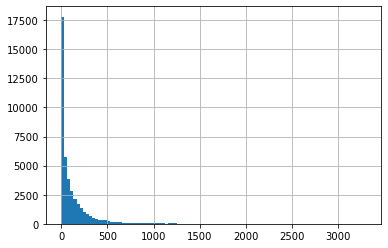

In [79]:
data.days_between_reviews.hist(bins=100)

По выбросам мы видим, что хвост тянется непрерывно до 1200. Давайте посмотрим, сколько у нас таких значений и сгладим выбросы.

In [80]:
len(data.query('days_between_reviews > 1200'))

285

In [81]:
data.days_between_reviews = data.days_between_reviews.apply(lambda x: 1200 if x > 1200 else x)

In [82]:
data.days_between_reviews.isnull().sum()

8112

Пропусков много, заполним пропуски медианой.

In [83]:
data.days_between_reviews.describe()

count    41888.000000
mean       120.315651
std        190.546256
min          0.000000
25%          8.000000
50%         49.000000
75%        148.000000
max       1200.000000
Name: days_between_reviews, dtype: float64

In [84]:
data.days_between_reviews = data.days_between_reviews.fillna(data.days_between_reviews.median())

In [85]:
# проверяем

data.days_between_reviews.isnull().sum()

0

Добавим еще один признак - кол-во дней с последнего отзыва до настоящего момента.

In [86]:
data['days_tillnow'] = data.date_of_review.apply(
    lambda x: None if x == [] else datetime.now() - pd.to_datetime(x).max())

In [87]:
data['days_tillnow'] = data['days_tillnow'].apply(lambda x: x.days)

In [88]:
data.days_tillnow.isnull().sum()

8112

In [89]:
data.days_tillnow.describe()

count    41888.000000
mean      1363.871276
std        382.403027
min       1073.000000
25%       1152.000000
50%       1226.500000
75%       1410.000000
max      18661.000000
Name: days_tillnow, dtype: float64

Заменим пропуски на среднее.

In [90]:
data.days_tillnow = data.days_tillnow.fillna(data.days_tillnow.mean())

### Посмотрим распределение признаков

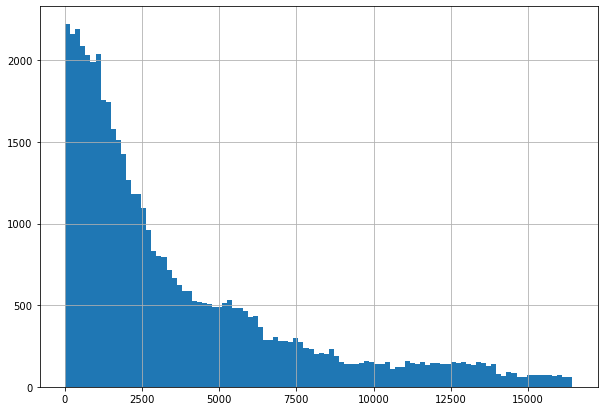

In [91]:
plt.rcParams['figure.figsize'] = (10,7)
data['ranking'].hist(bins=100)

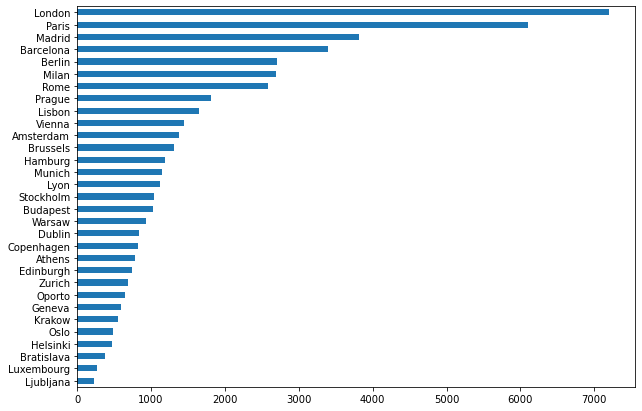

In [92]:
data['city'].value_counts(ascending=True).plot(kind='barh')

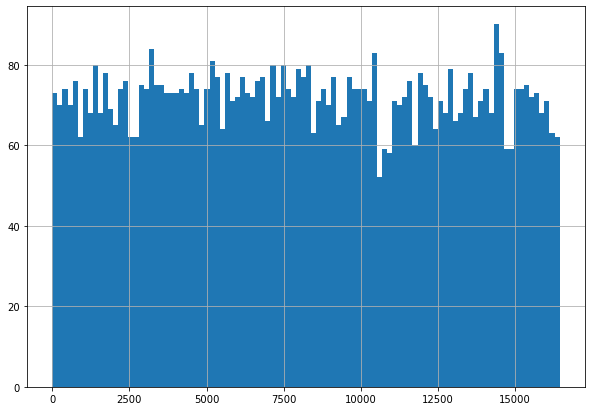

In [93]:
data['ranking'][data['city'] =='London'].hist(bins=100)

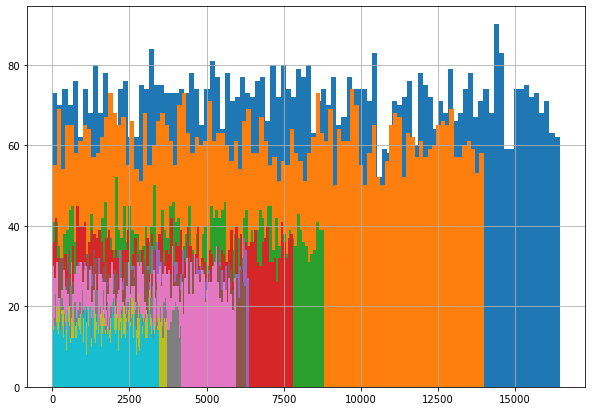

In [94]:
# посмотрим на топ 10 городов
for x in (data['city'].value_counts())[0:10].index:
    data['ranking'][data['city'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

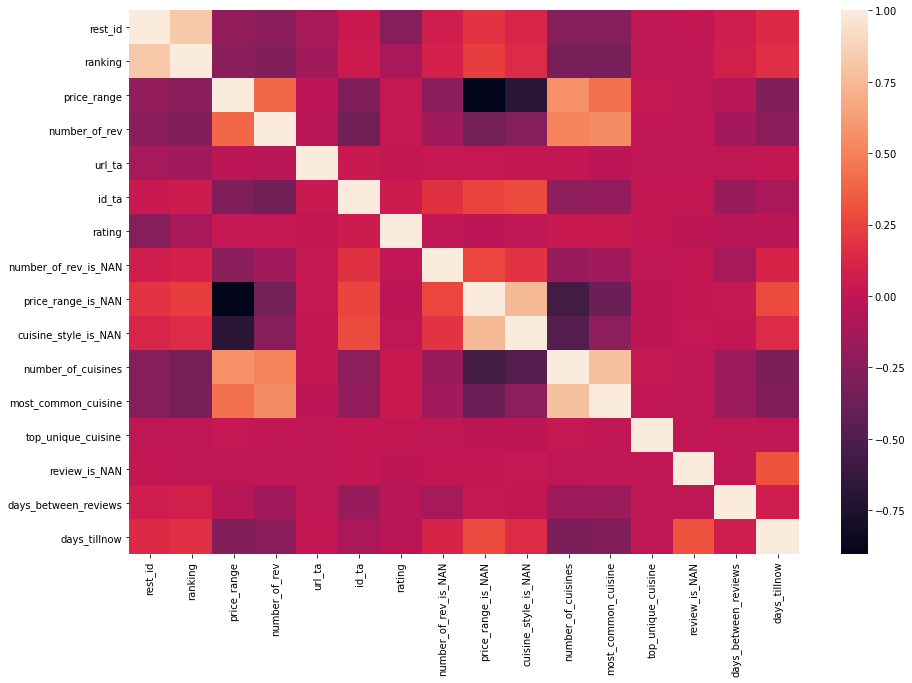

In [95]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Добавим несколько признаков, которые могут улучшить работу нашей модели.

In [96]:
# признак население (по информации из Википедии)

population = {
    'London' : 8909081,
    'Paris' : 2148271,
    'Madrid' : 3223334,
    'Barcelona' : 1620343,
    'Berlin' : 3769495,
    'Milan' : 1399860,
    'Rome' : 2860009,
    'Prague' : 1324277,
    'Lisbon' : 505526,
    'Vienna' : 2600000,
    'Amsterdam' : 872680,
    'Brussels' : 1208542,
    'Hamburg' : 1845229,
    'Munich' : 1484226,
    'Lyon' : 516092,
    'Stockholm' : 975904,
    'Budapest' : 1752286,
    'Warsaw' : 1793579,
    'Dublin' : 554554,
    'Copenhagen' : 794128,
    'Athens' : 664046,
    'Edinburgh' : 488050, 
    'Zurich' : 415215,
    'Oporto' : 287591,
    'Geneva' : 201818, 
    'Krakow' : 779115, 
    'Oslo' : 697549, 
    'Helsinki' : 656229,
    'Bratislava' : 437726,
    'Luxembourg' : 626108,
    'Ljubljana' : 295504
}

data['population'] = data.city.map(population)

In [97]:
# Признак - индекс покупательской способности согласно рейтингу Numbeo (2018)

purchasing_power_index = {
    'London' : 24,
    'Paris' : 22,
    'Madrid' : 23,
    'Barcelona' : 30,
    'Berlin' : 8,
    'Milan' : 40,
    'Rome' : 37,
    'Prague' : 31,
    'Lisbon' : 48,
    'Vienna' : 21,
    'Amsterdam' : 19,
    'Brussels' : 15,
    'Hamburg' : 7,
    'Munich' : 6,
    'Lyon' : 70,
    'Stockholm' : 13,
    'Budapest' : 51,
    'Warsaw' : 29,
    'Dublin' : 27,
    'Copenhagen' : 10,
    'Athens' : 53,
    'Edinburgh' : 16, 
    'Zurich' : 2,
    'Oporto' : 42,
    'Geneva' : 3, 
    'Krakow' : 36, 
    'Oslo' : 17, 
    'Helsinki' : 9,
    'Bratislava' : 39,
    'Luxembourg' : 4,
    'Ljubljana' : 32
}

data['purchasing_power'] = data.city.map(purchasing_power_index)

In [98]:
# Признак - является ли город столицей (1 - да, 0 - нет)

capital = ['London', 'Paris', 'Madrid', 'Berlin', 'Rome', 'Prague',
          'Lisbon', 'Vienna', 'Amsterdam', 'Brussels', 'Stockholm',
          'Budapest', 'Warsaw', 'Dublin', 'Copenhagen', 'Athens',
          'Edinburgh', 'Oslo', 'Helsinki', 'Bratislava',
          'Luxembourg', 'Ljubljana']
data['is_capital'] = data.city.apply(lambda x: 1 if x in capital else 0)

In [99]:
# Добавим признак кол-ва ресторанов в городе

number_of_rest_city = data.groupby('city')['ranking'].count().to_dict()
data['rest_city_count'] = data.city.map(number_of_rest_city)

In [100]:
# Добавим признак относительного ранга ресторана по городу

data['city_ranking'] = data.ranking / data.rest_city_count

С городами пока все. Идем дальше. Повизуализируем еще.

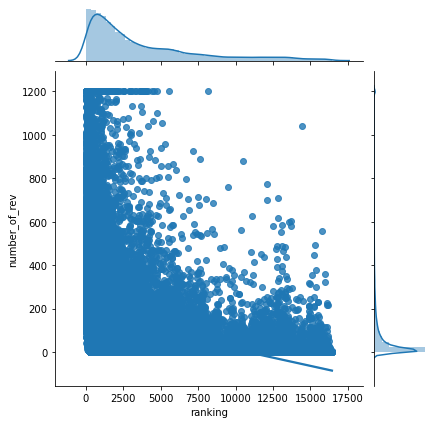

In [101]:
sns.jointplot(x = 'ranking', y = 'number_of_rev', data = data, kind = 'reg')

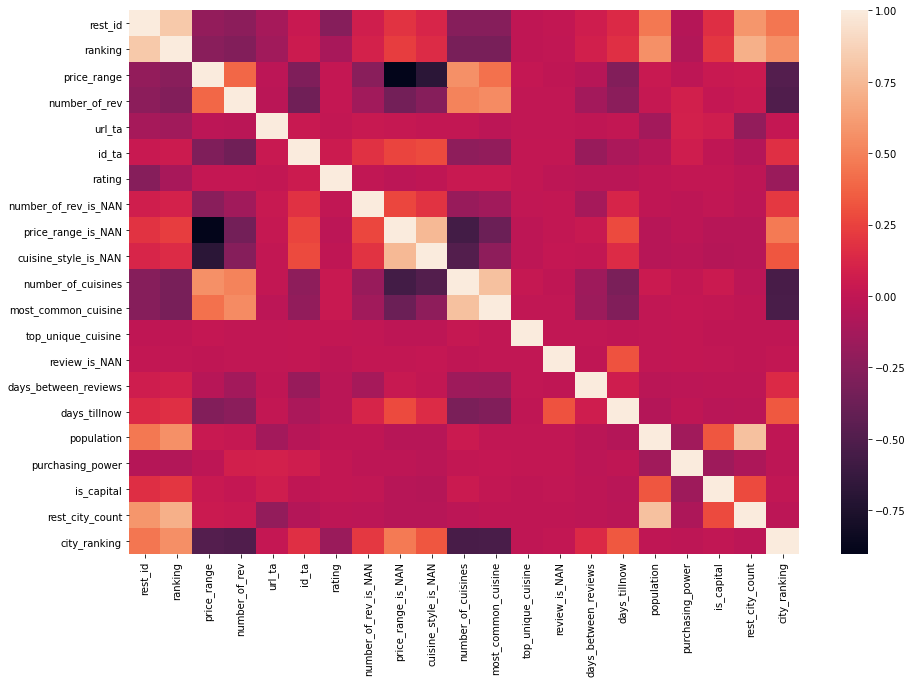

In [102]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Добавим следующие признаки:
- ранг ресторана на основании кол-ва отзывов
- соотношение кол-ва отзывов и населения города

In [103]:
# ранг ресторана на основании кол-ва отзывов

data['ranking_rev_count'] = data.ranking * data.number_of_rev

In [104]:
# соотношение кол-ва отзывов и населения города

data['reviews_per_city_pop'] = data.number_of_rev / data.population

In [105]:
# Признак среднее кол-во отзывов в городе

mean_rev_per_city = data.groupby('city')['number_of_rev'].mean()
mean_rev_per_city = mean_rev_per_city.apply(lambda x: round(x, 2))
data['mean_rev_per_city'] = data.city.map(mean_rev_per_city)

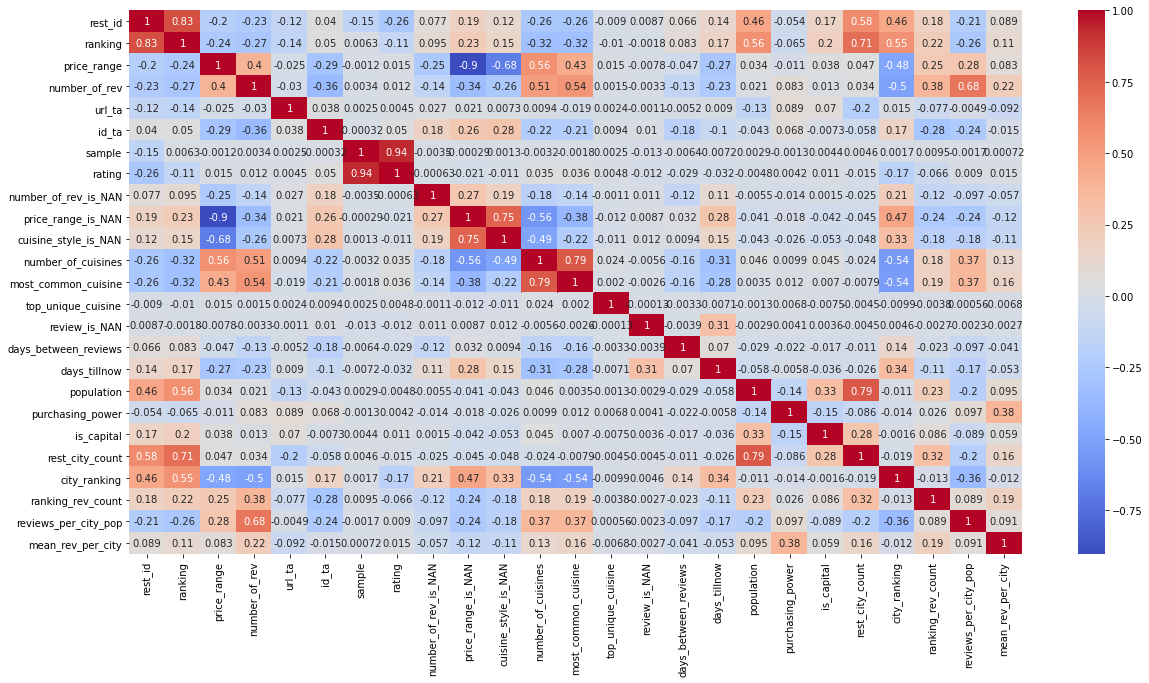

In [106]:
fig, ax = plt.subplots(1,1, figsize = (20,10))
ax = sns.heatmap(data.corr(),annot = True, cmap = 'coolwarm')

In [107]:
# Добавим признак туристическая привлекательность.
# Место города в рейтинге топ-100 городов посещения в 2018 году (так как датасет устаревший)
# Источник - Euromonitor international

# Так как не все города входят в топ-100, то города делим на группы:
# 1 - место 1-25
# 2 - место 26-50
# 3 - место 51-75
# 4 - место 76-100
# 5 - место выше 100

tourist_attract = {
    'London' : 1,
    'Paris' : 1,
    'Madrid' : 2,
    'Barcelona' : 2,
    'Berlin' : 2,
    'Milan' : 5,
    'Rome' : 1,
    'Prague' : 1,
    'Lisbon' : 3,
    'Vienna' : 2,
    'Amsterdam' : 1,
    'Brussels' : 3,
    'Hamburg' : 5,
    'Munich' : 3,
    'Lyon' : 5,
    'Stockholm' : 4,
    'Budapest' : 3,
    'Warsaw' : 3,
    'Dublin' : 5,
    'Copenhagen' : 3,
    'Athens' : 2,
    'Edinburgh' : 5, 
    'Zurich' : 5,
    'Oporto' : 4,
    'Geneva' : 5, 
    'Krakow' : 3, 
    'Oslo' : 5, 
    'Helsinki' : 5,
    'Bratislava' : 5,
    'Luxembourg' : 5,
    'Ljubljana' : 5
}

data['tourist_attract'] = data.city.map(tourist_attract)

Так как у нас есть связь между городом и рангам большая и она сильно влияет на модель, создадим вспомогательный признак максимального ранга по городу.

In [108]:
# Максимальный ранг

ranking_max_per_city = data.groupby('city')['ranking'].max()
data['rating_max_per_city'] = data.city.map(ranking_max_per_city)

### Отбор признаков

В ходе работы над проектом были также добавлены следующие признаки: длина отзыва, входит ле ресторан в сеть ресторанов, среднее кол-во туристов в городе, принадлежность к той или иной стране. Однако данные признаки ухудшили работу модели и от них было принято решение отказаться.

Также экспериментально было выяснено, что признаки rest_id, number_of_rev_is_NAN, review_is_NAN, is_capital также увеличивают MAE в итоге. Так что в при отборе признаков для модели, они также не учитывались.

## Закодируем признаки

In [109]:
data = pd.get_dummies(data, columns=['city'], dummy_na=True)

## Data Preprocessing

In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 62 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   rest_id               50000 non-null  float64
 1   cuisine_style         50000 non-null  object 
 2   ranking               50000 non-null  float64
 3   price_range           50000 non-null  float64
 4   number_of_rev         50000 non-null  float64
 5   reviews               49998 non-null  object 
 6   url_ta                50000 non-null  float64
 7   id_ta                 50000 non-null  int64  
 8   sample                50000 non-null  int64  
 9   rating                50000 non-null  float64
 10  number_of_rev_is_NAN  50000 non-null  uint8  
 11  price_range_is_NAN    50000 non-null  uint8  
 12  cuisine_style_is_NAN  50000 non-null  uint8  
 13  number_of_cuisines    50000 non-null  int64  
 14  most_common_cuisine   50000 non-null  int64  
 15  top_unique_cuisine 

In [111]:
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 100)  # показывать больше колонок

data.sample(5)

,rest_id,cuisine_style,ranking,price_range,number_of_rev,reviews,url_ta,id_ta,sample,rating,number_of_rev_is_NAN,price_range_is_NAN,cuisine_style_is_NAN,number_of_cuisines,most_common_cuisine,top_unique_cuisine,review_is_NAN,date_of_review,days_between_reviews,days_tillnow,population,purchasing_power,is_capital,rest_city_count,city_ranking,ranking_rev_count,reviews_per_city_pop,mean_rev_per_city,tourist_attract,rating_max_per_city,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,city_nan
20391,2352.0,[Other],2355.0,0.0,3.0,"[[], []]",189158.0,5988347,1,3.5,0,1,1,1,1,0,0,[],49.0,1363.871276,505526,48,1,1647,1.429872,7065.0,0.000006,109.72,3,3717.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5793,5793.0,"[Spanish, Mediterranean, Gluten Free Options]",408.0,3.0,112.0,[['Excellent steak house near Sagrada Familia'...,187497.0,12873128,0,0.0,0,0,0,3,2,0,0,"[01/07/2018, 01/03/2018]",4.0,1123.000000,1620343,30,0,3395,0.120177,45696.0,0.000069,116.13,2,7796.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
927,927.0,"[French, European, Vegetarian Friendly]",1071.0,2.0,204.0,"[['I strongly recommend this place', 'Nice sur...",187147.0,942681,0,0.0,0,0,0,3,3,0,0,"[06/10/2017, 04/28/2017]",43.0,1334.000000,2148271,22,1,6108,0.175344,218484.0,0.000095,107.36,1,13986.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
41513,152.0,"[French, Belgian, European]",153.0,3.0,337.0,"[['Congratulations', 'Perfection'], ['09/18/20...",188644.0,1091593,1,4.0,0,0,0,3,2,0,0,"[09/18/2017, 05/30/2017]",111.0,1234.000000,1208542,15,1,1314,0.116438,51561.0,0.000279,80.42,3,3006.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14294,1894.0,"[Japanese, Austrian, European]",1896.0,2.0,3.0,"[['Relaxing Atmosphere'], ['01/29/2017']]",190454.0,11652763,1,5.0,0,0,0,3,1,0,0,[01/29/2017],0.0,1466.000000,2600000,21,1,1443,1.313929,5688.0,0.000001,67.73,2,3444.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [112]:
df_preproc = data.drop(
    ['rest_id', 'cuisine_style', 'reviews', 'date_of_review',
    'number_of_rev_is_NAN', 'review_is_NAN', 'is_capital'], axis=1)

In [113]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 55 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ranking               50000 non-null  float64
 1   price_range           50000 non-null  float64
 2   number_of_rev         50000 non-null  float64
 3   url_ta                50000 non-null  float64
 4   id_ta                 50000 non-null  int64  
 5   sample                50000 non-null  int64  
 6   rating                50000 non-null  float64
 7   price_range_is_NAN    50000 non-null  uint8  
 8   cuisine_style_is_NAN  50000 non-null  uint8  
 9   number_of_cuisines    50000 non-null  int64  
 10  most_common_cuisine   50000 non-null  int64  
 11  top_unique_cuisine    50000 non-null  int64  
 12  days_between_reviews  50000 non-null  float64
 13  days_tillnow          50000 non-null  float64
 14  population            50000 non-null  int64  
 15  purchasing_power   

In [114]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.

In [115]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [116]:
# проверяем

test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 54), (40000, 54), (40000, 53), (32000, 53), (8000, 53))

## Model

In [117]:
# Создаём модель 

model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [118]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [119]:
# Так как признак рейтинга имеет шаг 0.5, округляем предсказание.

y_pred = np.round(y_pred * 2) / 2

In [120]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1626875


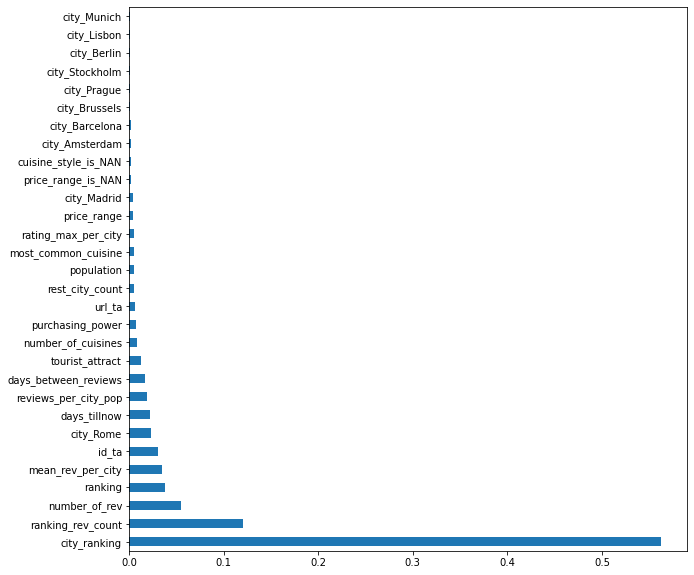

In [121]:
# Посмотрим самые важные признаки для модели

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

## Submission

In [122]:
test_data.sample(10)

,ranking,price_range,number_of_rev,url_ta,id_ta,rating,price_range_is_NAN,cuisine_style_is_NAN,number_of_cuisines,most_common_cuisine,top_unique_cuisine,days_between_reviews,days_tillnow,population,purchasing_power,rest_city_count,city_ranking,ranking_rev_count,reviews_per_city_pop,mean_rev_per_city,tourist_attract,rating_max_per_city,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,city_nan
9046,8762.0,1.0,10.0,186338.0,10815566,0.0,0,0,5,1,0,35.0,1254.000000,8909081,24,7193,1.218129,87620.0,1.122450e-06,117.09,1,16444.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4201,1033.0,0.0,0.0,274856.0,12030280,0.0,1,1,1,1,0,0.0,1482.000000,1793579,29,925,1.116757,0.0,0.000000e+00,56.84,3,2154.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5794,990.0,2.0,34.0,113649.0,12785767,0.0,0,0,3,1,0,176.0,1074.000000,1208542,15,1314,0.753425,33660.0,2.813307e-05,80.42,3,3006.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3320,1069.0,3.0,277.0,187147.0,719211,0.0,0,0,2,2,0,40.0,1125.000000,2148271,22,6108,0.175016,296113.0,1.289409e-04,107.36,1,13986.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2588,169.0,2.0,113.0,188113.0,6989781,0.0,0,0,7,2,0,122.0,1251.000000,415215,2,685,0.246715,19097.0,2.721482e-04,67.15,5,1601.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3715,1663.0,0.0,7.0,187265.0,3958349,0.0,1,0,2,2,0,254.0,1404.000000,516092,70,1126,1.476909,11641.0,1.356347e-05,82.77,5,2666.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1522,5490.0,0.0,5.0,187791.0,10831262,0.0,1,1,1,1,0,49.0,1363.871276,2860009,37,2589,2.120510,27450.0,1.748246e-06,250.88,1,5948.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4314,1731.0,2.0,42.0,189541.0,4509673,0.0,0,0,4,1,0,86.0,1592.000000,794128,10,819,2.113553,72702.0,5.288820e-05,87.09,3,1964.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2055,10772.0,0.0,6.0,186338.0,10094682,0.0,1,1,1,1,0,24.0,1385.000000,8909081,24,7193,1.497567,64632.0,6.734701e-07,117.09,1,16444.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8024,93.0,3.0,703.0,186338.0,2468914,0.0,0,0,5,2,0,0.0,1125.000000,8909081,24,7193,0.012929,65379.0,7.890825e-05,117.09,1,16444.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [123]:
test_data = test_data.drop(['rating'], axis=1)

In [124]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [125]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [126]:
predict_submission = np.round(predict_submission * 2)/2

In [127]:
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [128]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,2.0
8,id_8,4.0
9,id_9,4.5
